# Softmax classification

In [22]:
import numpy as np
import matplotlib.pyplot as plt

__Loading the data__
- Let’s now import the digits dataset provided by scikit-learn:

In [23]:
#It contains 1797 small (8x8) black and white images of digits between 0 and 9.
from sklearn.datasets import load_digits
digits = load_digits()

N, w, h = digits.images.shape
d = w * h # number of pixels
c = len(digits.target_names) # number of classes

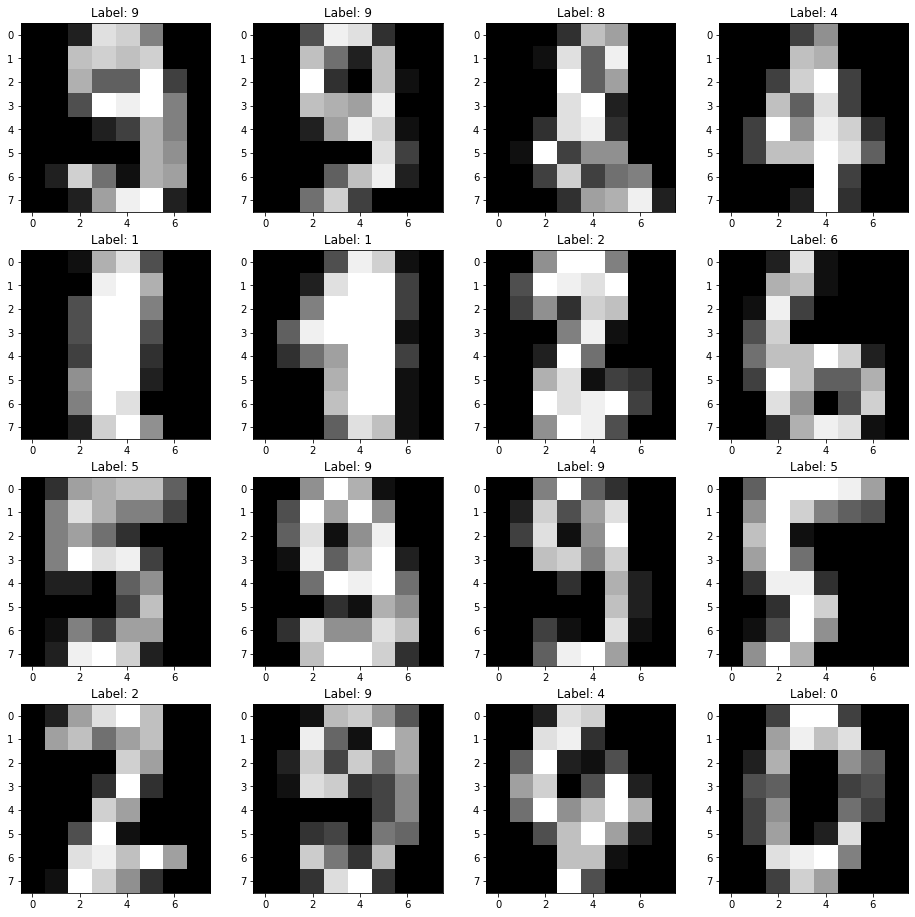

In [24]:
#This cells load the data and visualize 16 images chosen randomly.
rng = np.random.default_rng()
indices = rng.choice(N, 16)
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(digits.images[indices[i], :], cmap="gray")
    plt.title("Label: "+ str(digits.target[indices[i]]))
plt.show()

Digits are indeed to be recognized, the hope being that they are linearly separable and we can apply a softmax classifier directly on the pixels. But we will first __reshape__ the 8x8 images to a vector of size 64:

In [25]:
X = digits.images.reshape((N, d))
print(X.shape)

(1797, 64)


In [28]:
#Let’s know have a look at the targets, i.e. the ground truth / labels of each digit:
labels = digits.target
print(labels)
print(labels.shape)

[0 1 2 ... 8 9 8]
(1797,)


Each label is an integer between 0 and 9, while our softmax classifier expects a one-hot-encoded vector of 10 classes, with only one non-zero element. To do the conversion, we can once again use a built-in method of scikit-learn:

In [30]:
from sklearn.preprocessing import OneHotEncoder

t = OneHotEncoder().fit_transform(labels.reshape(-1, 1)).toarray()

print(t)
print(t.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
(1797, 10)


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3)

N_train = X_train.shape[1]
N_test = X_test.shape[0]

print(N_train, "training samples,", N_test, "test samples.")

64 training samples, 540 test samples.


__Softmax linear classifier__ 

The input vector X is transformed into a logit score vector Z using a weight matrix W and a bias vector b:
        Z = W x X + b
- The following Python function allows to turn any vector Z (numpy array) into softmax probabilities:

In [38]:
def softmax(z):
    e = np.exp(z - z.max())
    return e/np.sum(e)

In [39]:
z = np.array([-1, 0, 2])
s = softmax(z)
print(s)

[0.04201007 0.1141952  0.84379473]


Final training error: 0.0
Final training loss: 0.006365489242180564
Final test error: 0.12222222222222222
Final test loss: 0.12222222222222222


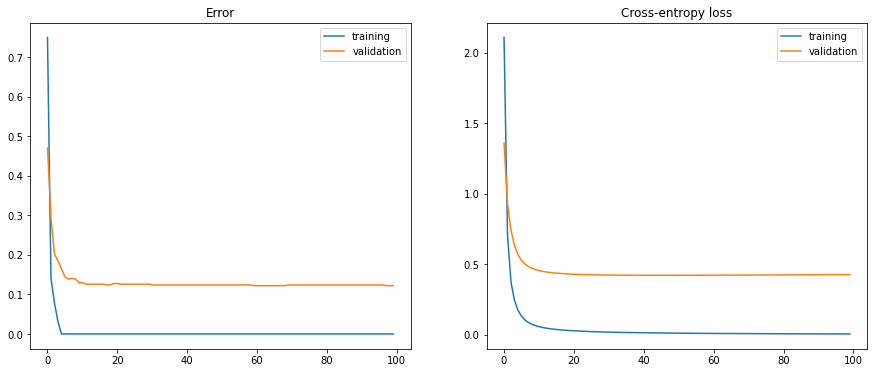

In [40]:
# Parameters
eta = 0.001
nb_epochs = 100

# Initialize the weight matrix and bias vector
W = np.zeros((c, d))
b = np.zeros(c)

# Perceptron algorithm
training_errors = []
training_losses = []
test_errors = []
test_losses = []

for epoch in range(nb_epochs):
    error = 0
    loss = 0.
    
    # Iterate over all training examples
    for i in range(N_train):
        
        # Prediction
        z = np.dot(W, X_train[i, :]) + b
        
        # Probability
        y = softmax(z)
        
        # Update the weight
        W += eta * np.outer((t_train[i, :] - y), X_train[i, :])
        
        # Update the bias
        b += eta * (t_train[i, :] - y) 
        
        # Increment the error if the maximum probability is different from the class
        if y.argmax() != t_train[i, :].argmax():
            error += 1
        
        # Accumulate the loss
        loss -= np.log(y[t_train[i, :].argmax()])
        
    training_errors.append(error/N_train)
    training_losses.append(loss/N_train)

    # Test error
    error = 0
    loss = 0.

    # Iterate over all test examples
    for i in range(N_test):

        # Prediction
        z = np.dot(W, X_test[i, :]) + b

        # Probability
        y = softmax(z)

        # Increment the error if the maximum probability is different from the class
        if y.argmax() != t_test[i, :].argmax():
            error += 1

        # Accumulate the loss
        loss -= np.log(y[t_test[i, :].argmax()])

    test_errors.append(error/N_test)
    test_losses.append(loss/N_test)

print("Final training error:", training_errors[-1])
print("Final training loss:", training_losses[-1])

print("Final test error:", test_errors[-1])
print("Final test loss:", test_errors[-1])

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(training_errors, label="training")
plt.plot(test_errors, label="validation")
plt.legend()
plt.title("Error")
plt.subplot(122)
plt.plot(training_losses, label="training")
plt.plot(test_losses, label="validation")
plt.legend()
plt.title("Cross-entropy loss")
plt.show()

The training error reaches quickly 0, but the loss still decreases for a number of epochs. This is because the probability vector y is a correct prediction for the class (the maximum probability corresponds to the correct class) but not with a probability of 1 yet. The loss continues to evolve even when there is no error, as it wants to bring the probability vector as close as possible to a binary vector.

This is the main difference with the mean square error (mse) loss function: as soon as there are no errors, the mse loss becomes 0 and learning stops. In classification problems, one should therefore track the loss function, not the training error.

The test error is higher than the final training error. as the examples were not use for training. This is a classical sign of overfitting, although the model is linear. Regularization may help.

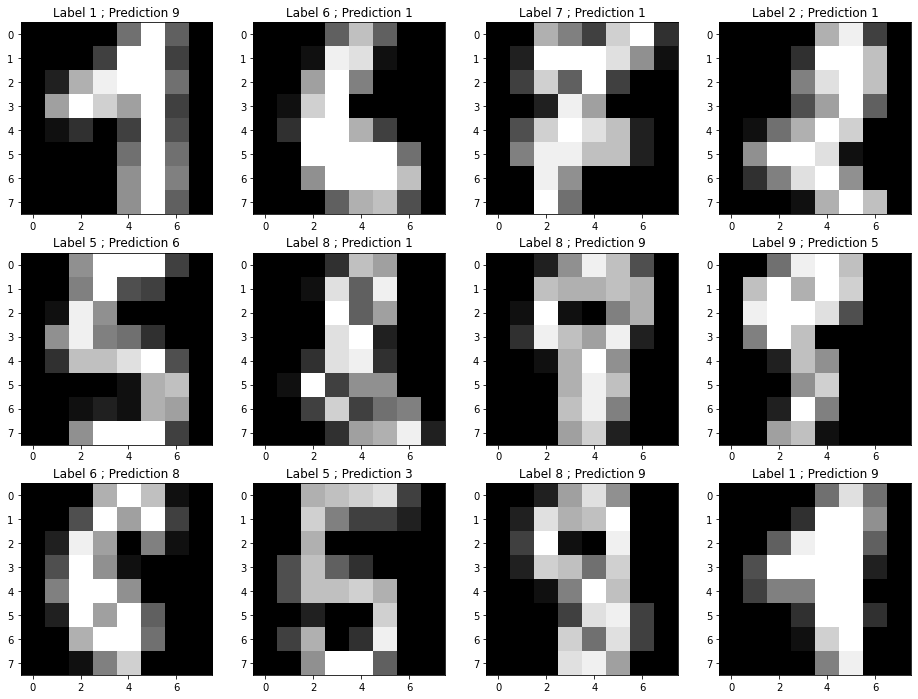

In [41]:
#The following cell samples 12 misclassified images from the test 
#and shows the predicted class together with the ground truth.
misclassified = []

for i in range(N_test):
    c = softmax(np.dot(W, X_test[i, :]) + b).argmax()
    if c != t_test[i, :].argmax():
        misclassified.append([X_test[i, :].reshape((8, 8)), t_test[i, :].argmax(), c])
        if len(misclassified) > 12: break
        
        
plt.figure(figsize=(16, 12))
for i in range(12):
    if i < len(misclassified):
        X, t, c = misclassified[i]
        plt.subplot(3, 4, i+1)
        plt.imshow(X, cmap="gray")
        plt.title("Label " + str(t) + " ; Prediction " + str(c))
    
plt.show()

For some misclassified images, the mistakes are quite understandable, so the classifier did a quite good job. Real-world data are never clean, there always are some bad annotations. It is therefore important to use methods that are robust to outliers, such as soft classifiers.